In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
import calendar
from pandas.api.types import CategoricalDtype

In [61]:
#Import data
customers = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_customers_dataset.csv')
locations = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_geolocation_dataset.csv')
items = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_items_dataset.csv')
payments = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_payments_dataset.csv')
reviews = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_reviews_dataset.csv')
orders = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_orders_dataset.csv')
products = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_products_dataset.csv')
product_category = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/product_category_name_translation%20(1).csv')

### Summary

In [44]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [71]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [62]:
datasets = [customers, locations, items, payments, reviews, orders, products, product_category]
col_names = ['customers', 'locations', 'items', 'payments', 'reviews', 'orders', 'products', 'product_category']

#To gather practical information about all datasets 
summary = pd.DataFrame({},)
summary['dataset'] = col_names
summary['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]
summary['cols_no'] = [df.shape[1] for df in datasets]
summary['null_no'] = [df.isnull().sum().sum() for df in datasets]
summary['null_cols_no']  = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
summary['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


summary.style.background_gradient(cmap = 'coolwarm')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,locations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,146532,2,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,product_category,"product_category_name, product_category_name_english",2,0,0,


### Merge Datasets

In [58]:
merge_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [60]:
products.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [63]:
#Merging Data
merge_df = pd.merge(orders, payments, on = 'order_id', how = 'inner')
merge_df = merge_df.merge(customers, on = 'customer_id', how = 'inner')
merge_df = merge_df.merge(items, on = 'order_id', how = 'inner')
merge_df = merge_df.merge(products, on = 'product_id', how = 'inner')
final_df = merge_df.merge(product_category, on="product_category_name")

# Drop NAs
final_df.dropna(inplace=True)  

### EDA 

Text(0.5, 1.0, 'Purchase by Month')

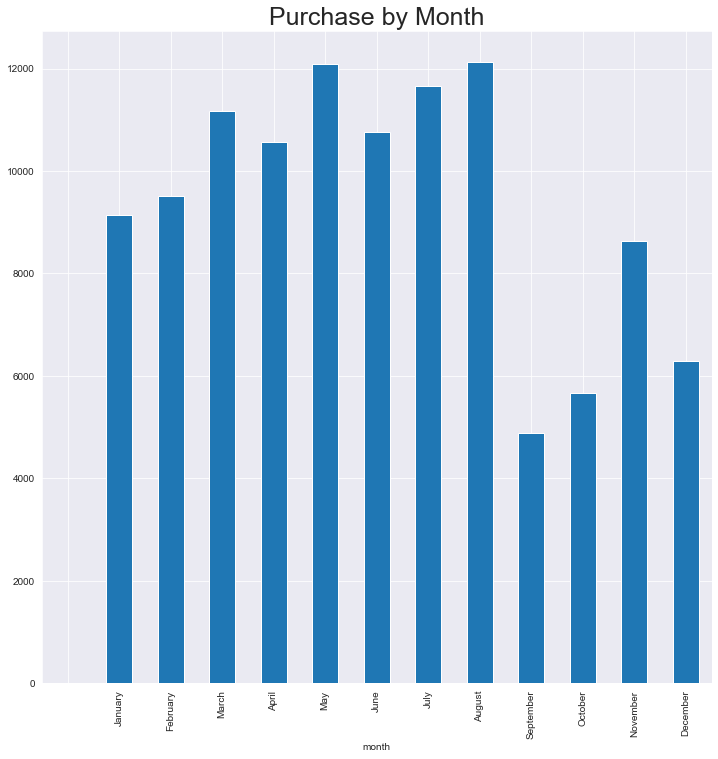

In [56]:
#Purchases by month
#Convert to datetime
final_df.order_purchase_timestamp_x = pd.to_datetime(final_df.order_purchase_timestamp_x)
final_df['month'] = pd.Series(pd.Categorical(final_df.order_purchase_timestamp_x.dt.month_name(), categories = list(calendar.month_name)))
#Groupby and plot
final_df.groupby('month').size().plot(kind = 'bar', figsize=(12,12))
plt.title('Purchase by Month',fontsize=25)

Text(0.5, 1.0, 'Purchases by Month')

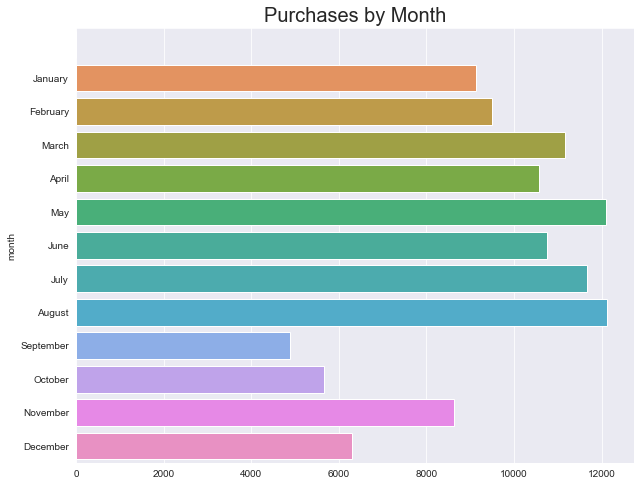

In [42]:
month = final_df.groupby('month').size().sort_values()
fig = plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.barplot(y = month.index, x = month.values)
plt.title('Purchases by Month',fontsize = 20)

Text(0.5, 1.0, 'Payment Types')

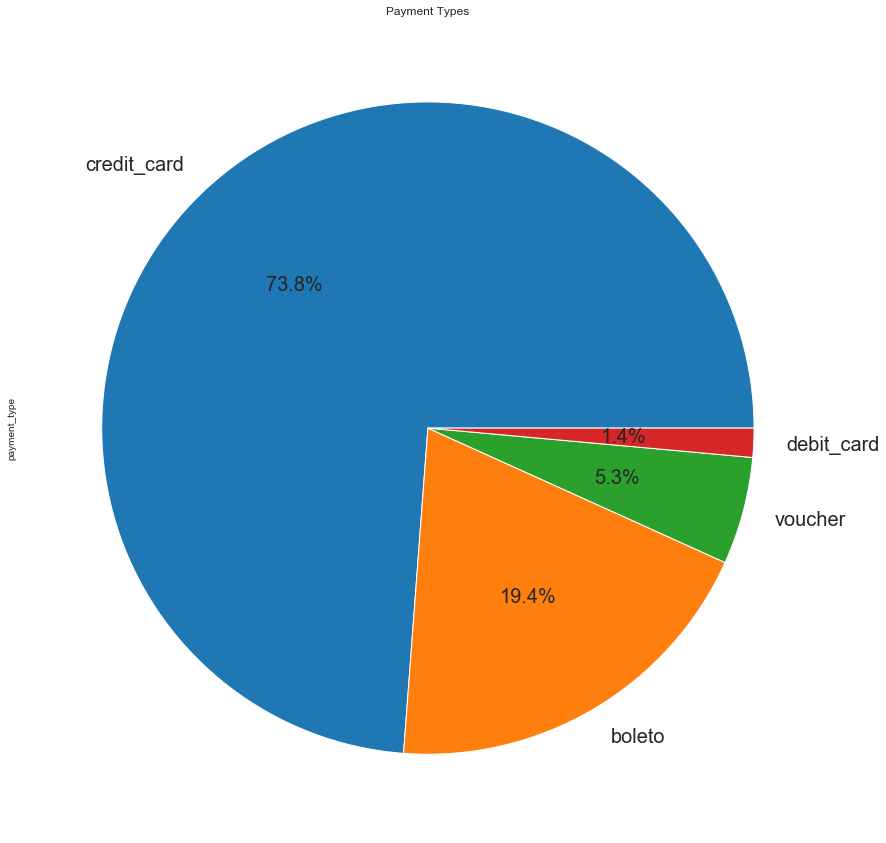

In [49]:
#Payment type
final_df.payment_type.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', fontsize = 20, figsize = (15, 15))
plt.title('Payment Types')

In [51]:
#Top Regions 
regions = final_df.customer_state.value_counts()
regions

SP    48511
RJ    14873
MG    13415
RS     6380
PR     5868
SC     4223
BA     3930
DF     2421
GO     2372
ES     2307
PE     1828
CE     1498
PA     1090
MT     1079
MS      835
MA      817
PB      623
RN      561
PI      553
AL      441
SE      386
TO      334
RO      281
AM      169
AC       94
AP       83
RR       46
Name: customer_state, dtype: int64

Text(0.5, 1.0, 'Sales by Regions')

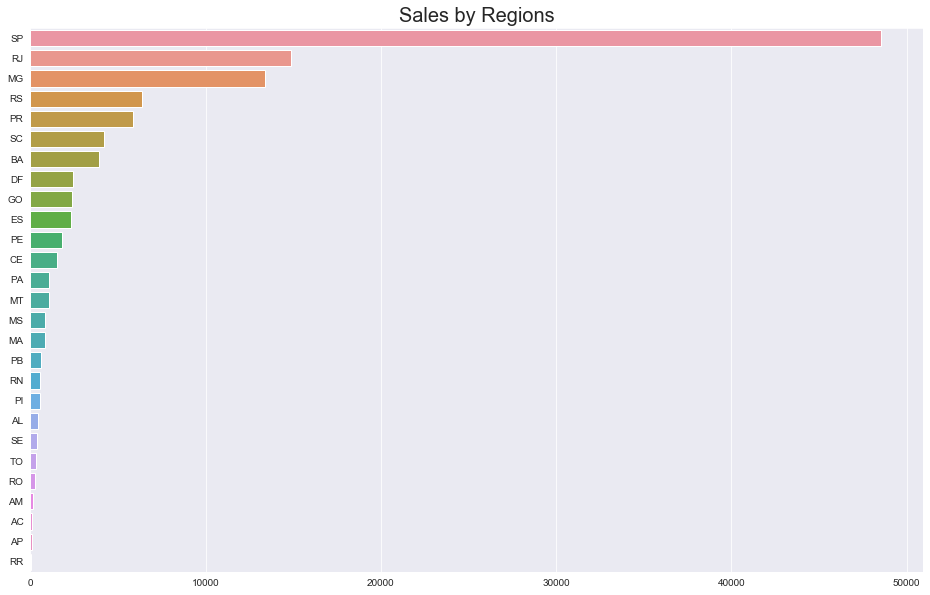

In [65]:
fig = plt.figure(figsize = (16, 10))
sns.set_style("darkgrid")
sns.barplot(y = regions.index, x = regions.values)
plt.title('Sales by Regions', fontsize = 20)

Text(0.5, 1.0, 'Top 20 Products')

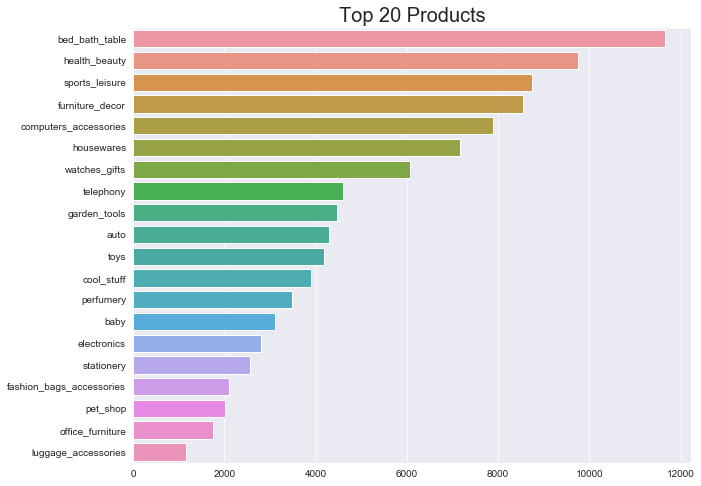

In [64]:
#Products
top_20 = final_df.product_category_name_english.value_counts()[:20]

fig=plt.figure(figsize = (10, 8))
sns.set_style('darkgrid')
sns.barplot(y = top_20.index, x = top_20.values)
plt.title('Top 20 Products', fontsize = 20)

Text(0.5, 1.0, 'Price Distribution')

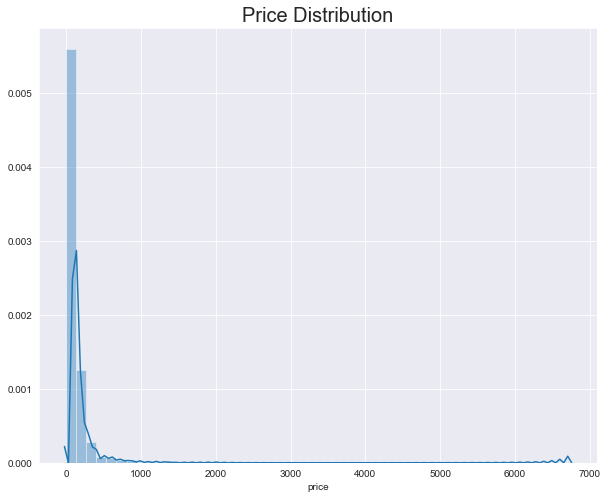

In [69]:
#Price 
fig = plt.figure(figsize = (10,8))
sns.set_style("darkgrid")
sns.distplot(final_df.price)
plt.title('Price Distribution', fontsize = 20)

In [70]:
final_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')